In [56]:
import cmaps
import random
import numpy as np
import pandas as pd 
import xarray as xr
import matplotlib as mpl 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy import stats 
from shapely import geometry 
from seam import precip, utils, nino34
from concurrent.futures import ProcessPoolExecutor
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)
             
%matplotlib inline 

random.seed(2024)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
num_samples = 10000

In [58]:
members = ['LE2-1001.001', 'LE2-1011.001', 'LE2-1021.002', 'LE2-1031.002', 'LE2-1041.003', 'LE2-1051.003',
            'LE2-1061.004', 'LE2-1071.004', 'LE2-1081.005', 'LE2-1091.005', 'LE2-1101.006', 'LE2-1111.006',
            'LE2-1121.007', 'LE2-1131.007', 'LE2-1141.008', 'LE2-1151.008', 'LE2-1161.009', 'LE2-1171.009',
            'LE2-1181.010', 'LE2-1191.010', 
            'LE2-1231.001', 'LE2-1231.002', 'LE2-1231.003', 'LE2-1231.004',
            'LE2-1231.005', 'LE2-1231.006', 'LE2-1231.007', 'LE2-1231.008', 'LE2-1231.009', 'LE2-1231.010',
            'LE2-1231.011', 'LE2-1231.012', 'LE2-1231.013', 'LE2-1231.014', 'LE2-1231.015', 'LE2-1231.016',
            'LE2-1231.017', 'LE2-1231.018', 'LE2-1231.019', 'LE2-1231.020',
            'LE2-1251.001', 'LE2-1251.002', 'LE2-1251.003', 'LE2-1251.004',
            'LE2-1251.005', 'LE2-1251.006', 'LE2-1251.007', 'LE2-1251.008', 'LE2-1251.009', 'LE2-1251.010',
            'LE2-1251.011', 'LE2-1251.012', 'LE2-1251.013', 'LE2-1251.014', 'LE2-1251.015', 'LE2-1251.016',
            'LE2-1251.017', 'LE2-1251.018', 'LE2-1251.019', 'LE2-1251.020',
            'LE2-1301.001', 'LE2-1301.002', 'LE2-1301.003', 'LE2-1301.004', 'LE2-1301.005', 'LE2-1301.006',
            'LE2-1301.007', 'LE2-1301.008', 'LE2-1301.009', 'LE2-1301.010', 'LE2-1301.011', 'LE2-1301.012', 
            'LE2-1301.013', 'LE2-1301.014', 'LE2-1301.015', 'LE2-1301.016', 'LE2-1301.017', 'LE2-1301.018',
            'LE2-1301.019', 'LE2-1301.020',
            'LE2-1281.001', 'LE2-1281.002', 'LE2-1281.003', 'LE2-1281.004', 'LE2-1281.005', 'LE2-1281.006',
            'LE2-1281.007', 'LE2-1281.008', 'LE2-1281.009', 'LE2-1281.010', 'LE2-1281.011', 'LE2-1281.012',
            'LE2-1281.013', 'LE2-1281.014', 'LE2-1281.015', 'LE2-1281.016', 'LE2-1281.017', 'LE2-1281.018',
            'LE2-1281.019', 'LE2-1281.020']

In [38]:
def get_running_corr(array1, array2, window=10, min_periods=5, center=True):
    """Define a mini function to apply a rolling correlation coefficient
    over a n-year window (default: 10 year)"""
    s1 = pd.Series(array1)
    s2 = pd.Series(array2)
    corr = s1.rolling(window, min_periods=min_periods, center=center).corr(s2)

    ds = xr.Dataset(
        data_vars=dict(
            corr=(["time"], corr.values),
        ),
        coords=dict(
            time=array1.time,
        ),
    )

    return ds['corr']


def get_model_sst_anomalies(ds, detrend=False):
    sst_ds = ds.sel(time=slice("1900-01", "2100-12"))
    sst_da = sst_ds["SST"]
    sst_anm_nino34_ersst = nino34.get_nino34_anm_timeseries(
        sst_da, detrend=detrend, base_start='1951-01', base_end='2015-12', filtered=True
    )
    sst_season = (
        sst_anm_nino34_ersst.resample(time="QS-DEC", label="left")
        .mean(dim='time')
        .sel(time=slice("1900-01", "2100-12"))
    )  # take quarterly means starting Dec 1
    nino34_DJF_ersst = (
        sst_season.sel(time=sst_season.time.dt.month.isin([12]))
        .resample(time="1Y")
        .mean()
    )

    return nino34_DJF_ersst


def convert_to_mm_per_month(group):
    # Convert m/s to mm/month 
    month = group.time.dt.month[0].item()  # Get the month number from the first item of the group
    
    # Seconds per month (non-leap years in CESM calendar)
    seconds_per_month = {
        1: 31 * 24 * 60 * 60,  # January
        2: 28 * 24 * 60 * 60,  # February (non-leap year)
        3: 31 * 24 * 60 * 60,  # March
        4: 30 * 24 * 60 * 60,  # April
        5: 31 * 24 * 60 * 60,  # May
        6: 30 * 24 * 60 * 60,  # June
        7: 31 * 24 * 60 * 60,  # July
        8: 31 * 24 * 60 * 60,  # August
        9: 30 * 24 * 60 * 60,  # September
        10: 31 * 24 * 60 * 60,  # October
        11: 30 * 24 * 60 * 60,  # November
        12: 31 * 24 * 60 * 60   # December
    }
    return group * 1000 * seconds_per_month[month]


def get_model_precip_anomalies(ds, months, detrend=False):
    """Function to get area-averaged MSEA precip anomalies for the specified months 
    relative to 1951-2015 base period"""

    precip_ds = ds.sel(time=slice("1900-01", "2100-12"))
    precip_da = precip_ds["PRECT"]
    precip_anm = (
        precip.get_SEAM_anm_timeseries(
            precip_da,
            detrend=detrend,
            base_start='1951-01',
            base_end='2015-12',
            monsoon_season=False,
            monthly=True,
        ))
    precip_anm = precip_anm.sel(time=precip_anm.time.dt.month.isin(months))

    # Apply conversion on grouped data
    precip_mm_month = precip_anm.groupby('time.month').map(convert_to_mm_per_month)

    precip_anm = precip_mm_month.resample(time='1Y').mean(dim='time')

    return precip_anm
    

In [40]:
# For each ensemble member, create a timeseries of area-averaged: lead correlations, Nino3.4 DJF ssts, MSEA MAM precip (100x201)

N=13 #13-year correlation coefficient

def process_member(ens):
    print(f"Processing {ens}")
    sst_da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.SST.Nino34.nc")
    sst_anm = get_model_sst_anomalies(sst_da, detrend=False)
    
    prec_da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.PRECT.MSEA.nc")
    precip_anm = get_model_precip_anomalies(prec_da, months=[3,4,5], detrend=False)

    print("Getting running correlation...")
    corr_lead = get_running_corr(precip_anm, sst_anm.shift(time=1), window=N)
    
    return (corr_lead, precip_anm, sst_anm)
    
def main(members):
    lead_correlations = []
    all_precips = []
    all_ssts = []
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_member, members))
    for result in results:
        corr_lead, precip_anm, sst_anm = result
        lead_correlations.append(corr_lead)
        all_precips.append(precip_anm)
        all_ssts.append(sst_anm)
    return lead_correlations, all_precips, all_ssts

# Call function
lead_correlations, all_precips, all_ssts = main(members)

# Concatenate
lead_correlations_da = xr.concat(lead_correlations, dim='ensemble')
precips_da = xr.concat(all_precips, dim='ensemble')
ssts_da = xr.concat(all_ssts, dim='ensemble')

Processing LE2-1001.001
Processing LE2-1011.001
Processing LE2-1021.002
Processing LE2-1031.002
Processing LE2-1041.003
Processing LE2-1051.003
Processing LE2-1061.004
Processing LE2-1071.004
Processing LE2-1081.005
Processing LE2-1091.005
Processing LE2-1101.006
Processing LE2-1111.006
Processing LE2-1121.007
Processing LE2-1131.007
Processing LE2-1141.008
Processing LE2-1151.008Getting running correlation...Getting running correlation...


Processing LE2-1161.009

Processing LE2-1171.009Getting running correlation...Getting running correlation...

Processing LE2-1181.010
Getting running correlation...
Processing LE2-1191.010Processing LE2-1231.001

Getting running correlation...

Processing LE2-1231.003Processing LE2-1231.002
Getting running correlation...Getting running correlation...

Processing LE2-1231.005
Processing LE2-1231.004
Getting running correlation...Getting running correlation...

Processing LE2-1231.007Processing LE2-1231.006

Getting running correlation...Getting runn

In [41]:
# For each ensemble member, get timeseries of global precip maps
def process_member(ens):
    print(f"Processing {ens}")
    precip_da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.PRECT.msea.MAM.1900_2100.nc")
 
    return precip_da
    
def main(members):
    all_precips = []
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_member, members))
    for result in results:
        precip_anm = result
        all_precips.append(precip_anm)
    return all_precips


# Call function
msea_all_precips = main(members)

# Concatenate
msea_precips_ds = xr.concat(msea_all_precips, dim='ensemble')

Processing LE2-1001.001
Processing LE2-1011.001
Processing LE2-1021.002
Processing LE2-1031.002
Processing LE2-1041.003
Processing LE2-1051.003
Processing LE2-1061.004
Processing LE2-1071.004
Processing LE2-1081.005
Processing LE2-1091.005
Processing LE2-1101.006
Processing LE2-1111.006
Processing LE2-1121.007
Processing LE2-1131.007
Processing LE2-1141.008
Processing LE2-1151.008

Processing LE2-1161.009Processing LE2-1171.009

Processing LE2-1181.010Processing LE2-1191.010
Processing LE2-1231.001Processing LE2-1231.002

Processing LE2-1231.003
Processing LE2-1231.005
Processing LE2-1231.004
Processing LE2-1231.006
Processing LE2-1231.007
Processing LE2-1231.008
Processing LE2-1231.009
Processing LE2-1231.011Processing LE2-1231.010

Processing LE2-1231.013
Processing LE2-1231.012
Processing LE2-1231.014
Processing LE2-1231.015
Processing LE2-1231.016
Processing LE2-1231.017
Processing LE2-1231.018
Processing LE2-1231.019
Processing LE2-1231.020
Processing LE2-1251.001
Processing LE2-1

In [7]:
# For each ensemble member, get timeseries of global PSL maps (previously saved)
def process_member(ens):
    print(f"Processing {ens}")
    psl_da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.PSL.global.DJF.1900_2100.nc")
 
    return psl_da
    
def main(members):
    all_psls = []
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_member, members))
    for result in results:
        psl_anm = result
        all_psls.append(psl_anm)
    return all_psls


# Call function
globa_all_psls = main(members)

# Concatenate
globa_all_psls_ds = xr.concat(globa_all_psls, dim='ensemble')

Processing LE2-1001.001
Processing LE2-1011.001
Processing LE2-1021.002
Processing LE2-1031.002
Processing LE2-1041.003
Processing LE2-1051.003
Processing LE2-1061.004
Processing LE2-1071.004
Processing LE2-1081.005
Processing LE2-1091.005
Processing LE2-1101.006
Processing LE2-1111.006
Processing LE2-1121.007
Processing LE2-1131.007
Processing LE2-1141.008
Processing LE2-1151.008
Processing LE2-1161.009
Processing LE2-1171.009
Processing LE2-1181.010
Processing LE2-1191.010
Processing LE2-1231.001
Processing LE2-1231.002
Processing LE2-1231.003
Processing LE2-1231.004
Processing LE2-1231.005
Processing LE2-1231.006
Processing LE2-1231.007
Processing LE2-1231.008
Processing LE2-1231.009
Processing LE2-1231.010
Processing LE2-1231.011
Processing LE2-1231.012
Processing LE2-1231.013
Processing LE2-1231.014
Processing LE2-1231.016Processing LE2-1231.015

Processing LE2-1231.017
Processing LE2-1231.018
Processing LE2-1231.019
Processing LE2-1231.020
Processing LE2-1251.001
Processing LE2-1

In [61]:
# Select only 1900-2014 (exclude future)
precips_da_1900_2014 = precips_da.sel(time=slice('1900','2014'))
ssts_da_1900_2014 = ssts_da.sel(time=slice('1900','2014'))
lead_correlations_da_sel = lead_correlations_da.sel(time=slice('1900','2014'))

msea_precips_da = msea_precips_ds['PRECT'].sel(time=slice('1900','2014'))
precip_mm_month = msea_precips_da.groupby('time.month').map(convert_to_mm_per_month)

globa_all_psls_da = globa_all_psls_ds['PSL']
globa_all_psls_hPa = globa_all_psls_da / 100 # convert Pa to hPa


In [62]:
# List of available years to be indexed
years = list(range(1900, 2015))

In [63]:
# Randomly select 10,000 13-year timeseries between 1900-2014
correlations = []
random_members = []
random_starts = []

for _ in range(num_samples):

    # Generate a random time index (0=1900, 102=2014-1900-13+1)
    random_time = random.randint(0, 102)

    # Generate a random member index (between 0 and 100)
    random_member = random.randint(0, 99)

    pre = precips_da_1900_2014.isel(ensemble=random_member).isel(time=slice(random_time,random_time+13))
    st = ssts_da_1900_2014.isel(ensemble=random_member).isel(time=slice(random_time,random_time+13))

    corr = xr.corr(pre, st.shift(time=1), dim='time')

    correlations.append(corr.values.item())
    random_members.append(random_member)
    random_starts.append(years[random_time])

In [64]:
# Figure 2c and 2d
df = pd.DataFrame({'Correlations': correlations, 'Members': random_members, 'Years': random_starts})
df_sorted = df.sort_values(by=["Correlations"])

# Calculate quartiles
Q1 = df_sorted['Correlations'].quantile(0.25)
Q3 = df_sorted['Correlations'].quantile(0.75)

print(Q1)
print(Q3)

# Filter rows in the top quartile
top_quartile = df_sorted[df_sorted['Correlations'] >= Q3]
top_quartile = top_quartile.dropna()

# Filter rows in the bottom quartile
bottom_quartile = df_sorted[df_sorted['Correlations'] <= Q1]
bottom_quartile = bottom_quartile.dropna()

# Select top quartile and bottom quartile of correlations
df_neg = bottom_quartile
df_pos = top_quartile

print(df_pos.shape[0])
print(df_neg.shape[0])

df_random = df_sorted.sample(int(df_neg.shape[0]), random_state=541415) # since df_pos and df_neg have same shape, random has same shape


-0.770629101182488
-0.5583978071692828
2500
2500


In [46]:
# For each of the three categories: positive correlations, negative correlations, and random, 
# select MSEA precip slices 

def get_slices(pres_da_norm):
    pos_slices = []
    for index, row in df_pos.iterrows():
        ens = row['Members']
        year = row['Years']

        pre_ens = pres_da_norm.isel(ensemble=int(ens))
        pre_slice = pre_ens.sel(time=slice(str(int(year)), str(int(year)+13))).mean(dim='time')

        pos_slices.append(pre_slice)

    neg_slices = []
    for index, row in df_neg.iterrows():
        ens = row['Members']
        year = row['Years']

        pre_ens = pres_da_norm.isel(ensemble=int(ens))
        pre_slice = pre_ens.sel(time=slice(str(int(year)), str(int(year)+13))).mean(dim='time')

        neg_slices.append(pre_slice)

    random_slices = []
    for index, row in df_random.iterrows():
        ens = row['Members']
        year = row['Years']

        pre_ens = pres_da_norm.isel(ensemble=int(ens))
        pre_slice = pre_ens.sel(time=slice(str(int(year)), str(int(year)+13))).mean(dim='time')

        random_slices.append(pre_slice)

    return pos_slices, neg_slices, random_slices

In [65]:
pos_pre_slices, neg_pre_slices, random_pre_slices = get_slices(precip_mm_month)

pos_pre_slices_da = xr.concat(pos_pre_slices, dim='random')
neg_pre_slices_da = xr.concat(neg_pre_slices, dim='random')
random_pre_slices_da = xr.concat(random_pre_slices, dim='random')

pos_psl_slices, neg_psl_slices, random_psl_slices = get_slices(globa_all_psls_hPa)

pos_psl_slices_da = xr.concat(pos_psl_slices, dim='random')
neg_psl_slices_da = xr.concat(neg_psl_slices, dim='random')
random_psl_slices_da = xr.concat(random_psl_slices, dim='random')

In [66]:
from statsmodels.stats.multitest import multipletests

def correct_pvals(p_val, alpha_global, method='fdr=bh'):

    p_values = p_val

    # Flatten array and remove NaNs
    p_values_flat = p_values.flatten()
    non_nan_mask = ~np.isnan(p_values_flat)
    non_nan_pvals = p_values_flat[non_nan_mask]

    # Apply the Benjamini-Hochberg correction
    _, corrected_pvals, _, _ = multipletests(non_nan_pvals, alpha=alpha_global, method=method)

    # Place corrected p-values back into the original array, keeping NaNs intact
    corrected_p_values = np.full_like(p_values_flat, np.nan)
    corrected_p_values[non_nan_mask] = corrected_pvals

    # Reshape back to the original shape
    corrected_p_values = corrected_p_values.reshape(p_values.shape)

    return corrected_p_values


In [67]:
pvals = np.array([0.05,0.075,0.067,0.0625,0.10])


In [68]:
monotonic_pvals = np.minimum.accumulate(pvals[::-1])[::-1]


In [69]:
pre_data1 = pos_pre_slices_da.mean(dim='random') - random_pre_slices_da.mean(dim='random')
pre_t_val1, pre_p_val1 = stats.ttest_ind(pos_pre_slices_da, random_pre_slices_da, equal_var=False)
pre_p_val1 = correct_pvals(pre_p_val1, alpha_global=0.02, method='fdr_bh')


pre_data2 = neg_pre_slices_da.mean(dim='random') - random_pre_slices_da.mean(dim='random')
pre_t_val2, pre_p_val2 = stats.ttest_ind(neg_pre_slices_da, random_pre_slices_da, equal_var=False)
pre_p_val2 = correct_pvals(pre_p_val2, alpha_global=0.02, method='fdr_bh')

psl_data1 = pos_psl_slices_da.mean(dim='random') - random_psl_slices_da.mean(dim='random')
psl_t_val1, psl_p_val1 = stats.ttest_ind(pos_psl_slices_da, random_psl_slices_da, equal_var=False)
psl_p_val1 = correct_pvals(psl_p_val1, alpha_global=0.02, method='fdr_bh')

psl_data2 = neg_psl_slices_da.mean(dim='random') - random_psl_slices_da.mean(dim='random')
psl_t_val2, psl_p_val2 = stats.ttest_ind(neg_psl_slices_da, random_psl_slices_da, equal_var=False)
psl_p_val2 = correct_pvals(psl_p_val2, alpha_global=0.02, method='fdr_bh')


In [70]:
mpl.rcParams['hatch.linewidth'] = 0.4  # previous pdf hatch linewidth

def draw_anomalies(data, ax, p_val, vmin, vmax, levels, ticks, cmap, cbar=False, label=None, MSEA_box=False):
    im = ax.contourf(
                    data.lon,
                    data.lat,
                    data,
                    cmap=cmap,
                    norm=mpl.colors.CenteredNorm(),
                    transform=ccrs.PlateCarree(),
                    extend="both",
                    levels=levels
                    )

    sig = ax.contourf(
                    data.lon,
                    data.lat,
                    data.where(p_val<0.001),
                    cmap=cmap,
                    norm=mpl.colors.CenteredNorm(),
                    transform=ccrs.PlateCarree(),
                    extend="both",
                    hatches=['/////'],
                    levels=levels
                    )

    ax.set_global()

    if MSEA_box is True:
        geom = geometry.box(minx=90, maxx=110, miny=10, maxy=25)
        ax.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='red', facecolor='none', linewidth=0.5)


    ax.set_xticks([60, 120, 180, 240, 300],
                                crs=ccrs.PlateCarree())

    ax.set_xticklabels([60, 120, 180, 240, 300],fontsize=8)


    ax.set_yticks([-60, -30, 0, 30, 60], 
                                crs=ccrs.PlateCarree())
    ax.set_yticklabels([-60, -30, 0, 30, 60],fontsize=8)

    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    ax.coastlines(linewidth=0.5)
    gl = ax.gridlines(
            crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.1, color="gray", alpha=0.5
        )

    if cbar is True:
        cax,kw = mpl.colorbar.make_axes(ax, ticks=ticks, location='bottom', pad=0.05, shrink=0.80, aspect=25)
        cbar = fig.colorbar(im, cax=cax, label=label, **kw)
        cbar.ax.tick_params(labelsize=8)
        cbar.outline.set_visible(False)

    return im


/tmp/ipykernel_393151/2779503516.py:109: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('Fig4.png')
/tmp/ipykernel_393151/2779503516.py:109: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('Fig4.png')
/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


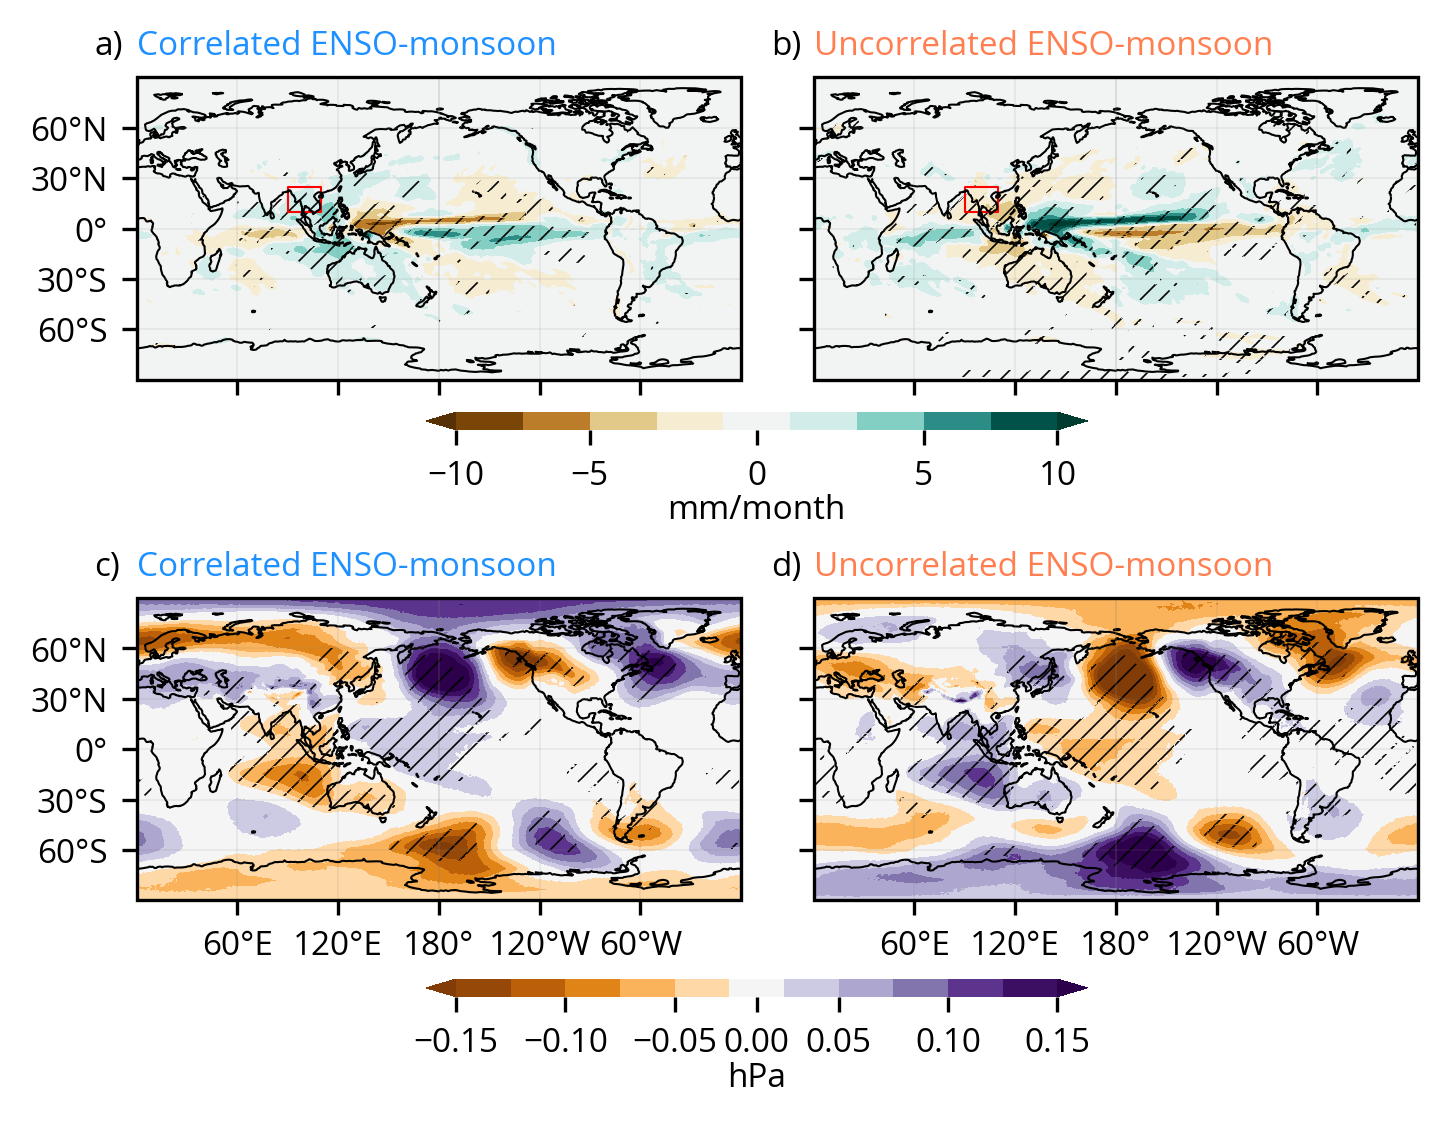

In [72]:
%matplotlib inline 
from matplotlib.gridspec import GridSpec

utils.set_matplotlib_font("Open Sans")
mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 8
})

fig_width_cm = 14
fig_height_cm = 10
fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_height_cm / 2.54

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300, constrained_layout=True)

gs1 = GridSpec(2, 2, top=0.90, bottom=0.2, hspace=0.7, wspace=0.12)

ax1 = fig.add_subplot(gs1[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax2 = fig.add_subplot(gs1[0, 1], projection=ccrs.PlateCarree(central_longitude=180))
ax3 = fig.add_subplot(gs1[1, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax4 = fig.add_subplot(gs1[1, 1], projection=ccrs.PlateCarree(central_longitude=180))

#gs1 = GridSpec(2, 1, left=0.10, right=0.40, bottom=0.15, hspace=0.4)
#ax1 = fig.add_subplot(gs1[0, 0])
#ax3 = fig.add_subplot(gs1[1, 0])

#gs2 = GridSpec(2, 1, left=0.48, right=0.90, height_ratios=[0.5, 0.5])
#ax2 = fig.add_subplot(gs2[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
#ax4 = fig.add_subplot(gs2[1, 0], projection=ccrs.PlateCarree(central_longitude=180))

############## Figure 4a ##############
im = draw_anomalies(pre_data2, ax1, pre_p_val2, 
                vmin=-10, 
                vmax=10, 
                levels=[-10, -7.5, -5, -2.5, -0.5, 0.5, 2.5, 5, 7.5, 10],
                ticks=[-10,-5, 0, 5, 10], 
                cmap=cmaps.MPL_BrBG,
                cbar=False, 
                label=None,
                MSEA_box=True)

ax1.set_xticklabels([])

############## Figure 4b ##############
im1 = draw_anomalies(pre_data1, ax2, pre_p_val1, 
                vmin=-10, 
                vmax=10,  
                levels=[-10, -7.5, -5, -2.5, -0.5, 0.5, 2.5, 5, 7.5, 10],
                ticks=[-10,-5, 0, 5, 10], 
                cmap=cmaps.MPL_BrBG,
                cbar=False, 
                label="mm/month",
                MSEA_box=True)


cbar_ax = fig.add_axes([0.3, 0.6, 0.4, 0.015])  # [left, bottom, width, height]
cbar = fig.colorbar(im1,  cax=cbar_ax, ticks=[-10,-5, 0, 5, 10], label="mm/month", orientation="horizontal", shrink=0.50)
cbar.outline.set_visible(False)
cbar.set_label("mm/month", labelpad=0.45, y=0.5, rotation=0)


############## Figure 4c ##############
im = draw_anomalies(psl_data2, ax3, psl_p_val2, 
                vmin=-.15, 
                vmax=.15, 
                levels=[-.15, -.125, -.10, -.075, -.05, -.025, .025, .05, .075, .10, .125, .15],
                ticks=[-.15, -.1, -.05, 0, 0.05, .1, .15], 
                cmap=cmaps.MPL_PuOr,
                cbar=False, 
                label=None,
                MSEA_box=False)
ax2.set_xticklabels([])
ax2.set_yticklabels([])


############## Figure 4d ##############
im2 = draw_anomalies(psl_data1, ax4, psl_p_val1, 
                vmin=-.15, 
                vmax=.15, 
                levels=[-.15, -.125, -.10, -.075, -.05, -.025, .025, .05, .075, .10, .125, .15],
                ticks=[-.15, -.1, -.05, 0, 0.05, .1, .15], 
                cmap=cmaps.MPL_PuOr,
                cbar=False, 
                label="hPa",
                MSEA_box=False)
ax4.set_yticklabels([])

# Set subplot labels
titles1 = ["a)", "b)", "c)", "d)"]
titles2 = ["Correlated ENSO-monsoon", "Uncorrelated ENSO-monsoon", "Correlated ENSO-monsoon", "Uncorrelated ENSO-monsoon"]
colors = ['dodgerblue', 'coral', 'dodgerblue', 'coral']
for i, (ax, title1, title2) in enumerate(zip([ax1, ax2, ax3, ax4], titles1, titles2)):
    ax.annotate(title1, xy=(-0.07, 1.05), xycoords='axes fraction', fontsize=8, color='k', ha='left', va='bottom')
    ax.annotate(title2, xy=(0, 1.05), xycoords='axes fraction', fontsize=8, color=colors[i], ha='left', va='bottom')
    #ax.spines['geo'].set_visible(False)


cbar_ax = fig.add_axes([0.3, 0.12, 0.4, 0.015])  # [left, bottom, width, height]
cbar = fig.colorbar(im2,  cax=cbar_ax, ticks=[-.15, -.1, -.05, 0, 0.05, .1, .15], orientation="horizontal", shrink=0.50)
cbar.outline.set_visible(False)
cbar.set_label("hPa", labelpad=0.5, y=0.5, rotation=0)

plt.savefig('Fig4.png')

In [55]:
pre_data2

<xarray.DataArray 'PRECT' (lat: 192, lon: 288)>
array([[-9.6900266e-13, -9.6900266e-13, -9.6922470e-13, ...,
        -9.6878061e-13, -9.6878061e-13, -9.6900266e-13],
       [-5.2637894e-12, -5.3466120e-12, -5.3996807e-12, ...,
        -5.0708326e-12, -5.1447735e-12, -5.2160498e-12],
       [-8.5504936e-12, -8.5007557e-12, -8.5043084e-12, ...,
        -8.8082874e-12, -8.7354568e-12, -8.6435303e-12],
       ...,
       [-2.7795544e-11, -2.7775560e-11, -2.7658764e-11, ...,
        -2.8471447e-11, -2.8279157e-11, -2.7925662e-11],
       [-2.7797764e-11, -2.7488678e-11, -2.7362113e-11, ...,
        -2.8406166e-11, -2.8208547e-11, -2.7940761e-11],
       [-2.2425617e-11, -2.2409630e-11, -2.2412738e-11, ...,
        -2.2421620e-11, -2.2450486e-11, -2.2425173e-11]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8